In [3]:
import torch
import torch.nn as nn
from torchviz import make_dot

# `Requires_grad`
Để pytorch lưu và tính toán đạo hàm của 1 tensor, mình gán thuộc tính requires_grad = True cho tensor đó và Pytorch chỉ cho phép float tensor được gán thuộc tính requires_grad = True.

Khi khởi tạo tensor thì mặc định requires_grad = False

In [4]:
a = torch.tensor([2., 3.])
a.requires_grad

False

In [5]:
# Gán thuộc tính requires_grad = True
a = torch.tensor([2., 3.], requires_grad=True)
a.requires_grad # True

# Hoặc
a = torch.tensor([2., 3.])
a.requires_grad = True


Thuộc tính requires_grad lây lan, tức là nếu a có requires_grad=True, thì các tensor khác được tính toán từ a, cũng sẽ có requires_grad=True.

In [ ]:
a = torch.tensor([2., 3.], requires_grad=True)
a.requires_grad # True
b = a**2
c = 2*b
print(b.requires_grad) # True
print(c.requires_grad) # True

Kể cả phép tính của 1 tensor có requires_grad và 1 tensor không có requires_grad thì output vẫn ra 1 tensor có requires_grad

In [6]:
a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([1., 1.])

print(a.requires_grad) # True
print(b.requires_grad) # False

c = a + b # [3., 4.]
print(c.requires_grad) # True

True
False
True


In [7]:
x = torch.tensor([3])
y = torch.tensor([10])
a = torch.tensor([1.], requires_grad=True)
b = torch.tensor([2.], requires_grad=True)

y_hat = a*x + b
z = y_hat - y
L = z**2

In [ ]:
print(x.is_leaf) # True
print(a.is_leaf) # True
print(y_hat.is_leaf) # False
print(L.is_leaf) # False

In [ ]:
L.backward()

print(a.grad) # -30
print(b.grad) # -10

Các tensor không phải leaf node và có autograd = True sẽ có thuộc tính grad_fn để lưu lại phép tính thực hiện ở bước đấy, để tính chain rule ngược lại.

In [8]:
print(x.grad_fn) # None
print(a.grad_fn) # None
print(y_hat.grad_fn) # AddBackward0
print(z.grad_fn) # SubBackward0
print(L.grad_fn) # PowBackward0

None
None


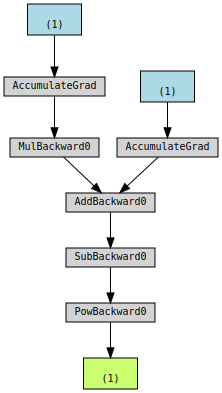

In [9]:
make_dot(L)

Các class MulBackward, AddBackward, SubBackward, PowBackward đều được kế thừa từ torch.Autograd.Function, trong đó có 2 hàm quan trọng:

def forward(ctx, input): nhận các tensor inputs, và trả về tensor output. Biến ctx để lưu lại các tensor cần thiết trong quá trình backward (chain rule).

def backward(ctx, grad_output): grad_output chứa đạo hàm của loss đến tensor ở node đấy, ctx lấy các giá trị lưu ở hàm forward để tính đạo hàm ngược qua node đó.

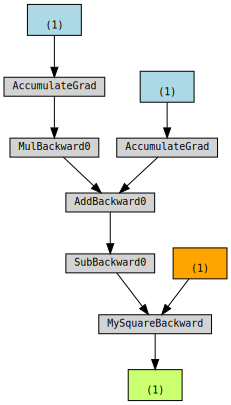

In [10]:
class MySquare(torch.autograd.Function):

  @staticmethod
  def forward(ctx, input):
    ctx.save_for_backward(input)
    return input**2

  @staticmethod
  def backward(ctx, grad_output):
    input, = ctx.saved_tensors
    return 2*input*grad_output

my_square = MySquare.apply

x = torch.tensor([3])
y = torch.tensor([10])
a = torch.tensor([1.], requires_grad=True)
b = torch.tensor([2.], requires_grad=True)

y_hat = a*x + b
z = y_hat - y
L = my_square(z)
make_dot(L)

In [11]:
x = torch.tensor([1., 2., 3.], requires_grad=True)
y = 2*x + 1
y.backward(gradient=torch.tensor([1, 2, 1]))

print(x.grad)

tensor([2., 4., 2.])


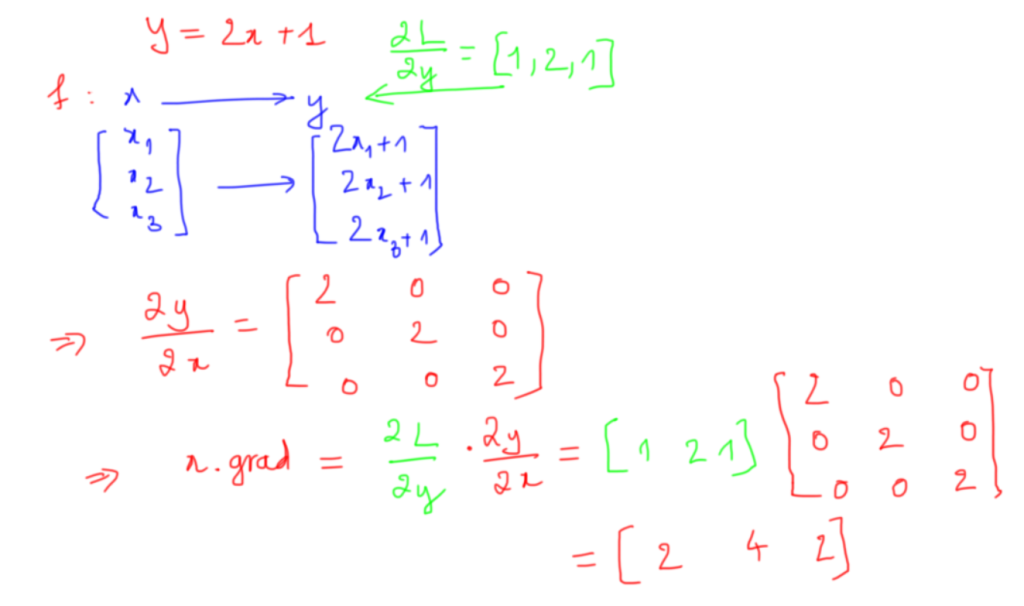

# `Computation Graph`

Khi tạo graph các non-leaf node (tensor) được cấp phát bộ nhớ, context (ctx) được tạo để lưu các biến tạm cho quá trình backward. Sau đó, khi gọi backward, thì đạo hàm được tính ngược lại cho các leaf tensor và sau đó graph bị hủy, vùng nhớ lưu các non-leaf node, biến tạm trong context được giải phóng. `Do đó mình không thể backward 2 lần liên tiếp.`

In [12]:
x = torch.tensor([1., 2., 3.], requires_grad=True)
y = 2*x + 1
z = sum(y)
z.backward()
print(x.grad)
z.backward() # RuntimeError: Trying to backward through the graph a second time 

tensor([2., 2., 2.])


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

Tuy nhiên khi train model DL, mình cần train nhiều epoch, mỗi epoch lại có nhiều step, nên mình cần gọi backward nhiều lần để tính đạo hàm ngược lại. Để thực hiện backward nhiều lần mình cần để thuộc tính retain_graph = True.

Tuy nhiên khi backward nhiều lần thì đạo hàm sẽ cộng dồn vào leaf tensor

In [13]:
x = torch.tensor([1., 2., 3.], requires_grad=True)
y = 2*x + 1
z = sum(y)

z.backward(retain_graph=True)
print(x.grad) # Output: tensor([2., 2., 2.])

z.backward(retain_graph=True)
print(x.grad) # Output: tensor([4., 4., 4.])

z.backward(retain_graph=True)
print(x.grad) # Output: tensor([6., 6., 6.])

x.grad.zero_()
print(x.grad) # Output: tensor([0., 0., 0.])

z.backward(retain_graph=True)
print(x.grad)


tensor([2., 2., 2.])
tensor([4., 4., 4.])
tensor([6., 6., 6.])
tensor([0., 0., 0.])
tensor([2., 2., 2.])


Thế nên khi ở mỗi step dùng gradient descent xong thường zero_grad trước khi sang step khác.

## Requires_grad = False

Trong quá trình chạy mình cũng có thể gán requires_grad = False cho tensor, ví dụ để freeze một vài layers không cập nhật hệ số, khi đó tensor sẽ không tham gia vào computation graph.

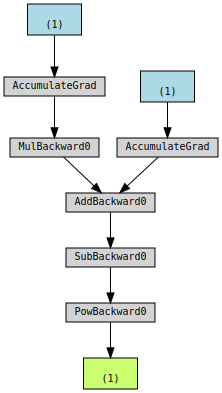

In [14]:
x = torch.tensor([3])
y = torch.tensor([10])
a = torch.tensor([1.], requires_grad=True)
b = torch.tensor([2.], requires_grad=True)
c = a*x
y_hat = c + b
z = y_hat - y
L = z**2
make_dot(L)

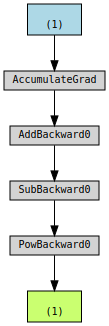

In [15]:
x = torch.tensor([3])
y = torch.tensor([10])
a = torch.tensor([1.], requires_grad=True)
a.requires_grad = False
b = torch.tensor([2.], requires_grad=True)
c = a*x
y_hat = c + b
z = y_hat - y
L = z**2
make_dot(L)

khi để a.requires_grad = False, thì a và c để được bỏ ra khỏi computation graph.

# `torch.no_grad()`

Trong quá trình inference thì mình không cần đạo hàm ngược lại nên không cần lưu giá trị biến tạm ở các node, mà đơn giản chỉ tính forward bình thường. Pytorch hỗ trợ context manager torch.no_grad cho việc này, khi nào mọi người không cần dùng backward thì hãy dùng torch.no_grad để giảm thiểu bộ nhớ và tính toán. Hay hiểu đơn giản hơn thì trong context của torch.no_grad thì tất cả các tensor có thuộc tính requires_grad = False

Ra ngoài context của torch.no_grad thì các thuộc tính của tensor autograd được dùng như bình thường.